In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import PIL
import math
import os
import random

from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [2]:
img_path = "./dataset/pkm"
checkpoint_path = "./checkpoint/image_gen.pth"
# os.remove('./data/images/indeedee-female.png') # corrupted image

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def to_pil_image(x):
    return Image.fromarray((x.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))

In [5]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, time_steps, d_model):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        self.embedding = torch.zeros(time_steps, d_model, requires_grad=False).to(device)
        self.embedding[:, 0::2] = torch.sin(position * div)
        self.embedding[:, 1::2] = torch.cos(position * div)

    def forward(self, x, t):
        return x + self.embedding[t, None, None, :x.shape[3], None]

In [6]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups, dropout_prob):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=in_channels)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=out_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)

    def forward(self, x):
        x = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(x)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return r + x

In [14]:
class UNet(nn.Module):
    def __init__(self, num_groups=32, dropout_prob=0.1):
        super().__init__()

        self.time_embedding = SinusoidalEmbedding(1000, 1000)
        self.down_scaler = nn.MaxPool2d(2, 2)
        self.enc1 = ResBlock(3, 64, 1, dropout_prob)
        self.enc2 = ResBlock(64, 128, num_groups, dropout_prob)
        self.enc3 = ResBlock(128, 256, num_groups, dropout_prob)
        self.enc4 = ResBlock(256, 512, num_groups, dropout_prob)

        self.neck_block = ResBlock(512, 1024, num_groups, dropout_prob)

        # self.upconv1 = nn.ConvTranspose2d(1024, 1024, 2, 2)
        self.upconv2 = nn.ConvTranspose2d(512, 512, 2, 2)
        self.upconv3 = nn.ConvTranspose2d(256, 256, 2, 2)
        self.upconv4 = nn.ConvTranspose2d(128, 128, 2, 2)

        self.dec1 = ResBlock(1024 + 512, 512, num_groups, dropout_prob)
        self.dec2 = ResBlock(512 + 256, 256, num_groups, dropout_prob)
        self.dec3 = ResBlock(256 + 128, 128, num_groups, dropout_prob)
        self.dec4 = ResBlock(128 + 64, 64, num_groups, dropout_prob)

        self.cls_conv = ResBlock(64, 3, 1, dropout_prob)

    def forward(self, x, t):
        x = self.time_embedding(x, t)
        enc1 = self.enc1(x)
        x = self.down_scaler(enc1)
        enc2 = self.enc2(x)
        x = self.down_scaler(enc2)
        enc3 = self.enc3(x)
        x = self.down_scaler(enc3)
        enc4 = self.enc4(x)
        x = enc4
        # x = self.down_scaler(enc4)

        x = self.neck_block(x)

        # x = self.upconv1(x)
        x = self.dec1(torch.cat((x, enc4), dim=1))
        x = self.upconv2(x)
        x = self.dec2(torch.cat((x, enc3), dim=1))
        x = self.upconv3(x)
        x = self.dec3(torch.cat((x, enc2), dim=1))
        x = self.upconv4(x)
        x = self.dec4(torch.cat((x, enc1), dim=1))

        x = self.cls_conv(x)
        return x

In [15]:
class LinearNoiseSchedule():
    def __init__(self, num_time_steps=1000):
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False).to(device)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False).to(device)
        self.sqrt_beta = torch.sqrt(self.beta).requires_grad_(False).to(device)
        self.sqrt_one_minus_beta = torch.sqrt(1 - self.beta).requires_grad_(False).to(device)
        self.sqrt_one_minus_alpha = torch.sqrt(1 - self.alpha).requires_grad_(False).to(device)

In [16]:
class DiffusionModel(nn.Module):
    def __init__(self, unet, noise_schedule):
        super().__init__()
        self.unet = unet
        self.noise_schedule = noise_schedule

    def forward(self, x, t, rand_factor=1.0):
        return self.denoise(x, t, rand_factor)

    def apply_noise(self, x, t, gradually=True):
        if gradually:
            noises = torch.randn(t, *x.shape).to(x.device)
            for i in range(t):
                x = x * self.noise_schedule.sqrt_one_minus_beta[i] + noises[i] * self.noise_schedule.sqrt_one_minus_alpha[i]
        else:
            noises = torch.randn_like(x)
            x = x * math.sqrt(self.noise_schedule.alpha[t]) + noises * math.sqrt(1 - self.noise_schedule.alpha[t])
        return x, noises

    def denoise(self, x, t, rand_factor=1.0):
        e_pred = self.unet(x, t)
        x = x - (self.noise_schedule.beta[t]) * e_pred / self.noise_schedule.sqrt_one_minus_alpha[t]
        x = (x / self.noise_schedule.sqrt_one_minus_beta[t]) + self.noise_schedule.sqrt_beta[t] * torch.randn_like(x) * rand_factor
        return x

In [17]:
max_training_epochs = 500
batch_size = 16
lr = 5e-4

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

noise_schedule = LinearNoiseSchedule()
diffusion_model = DiffusionModel(model, noise_schedule).to(device)

In [18]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=img_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

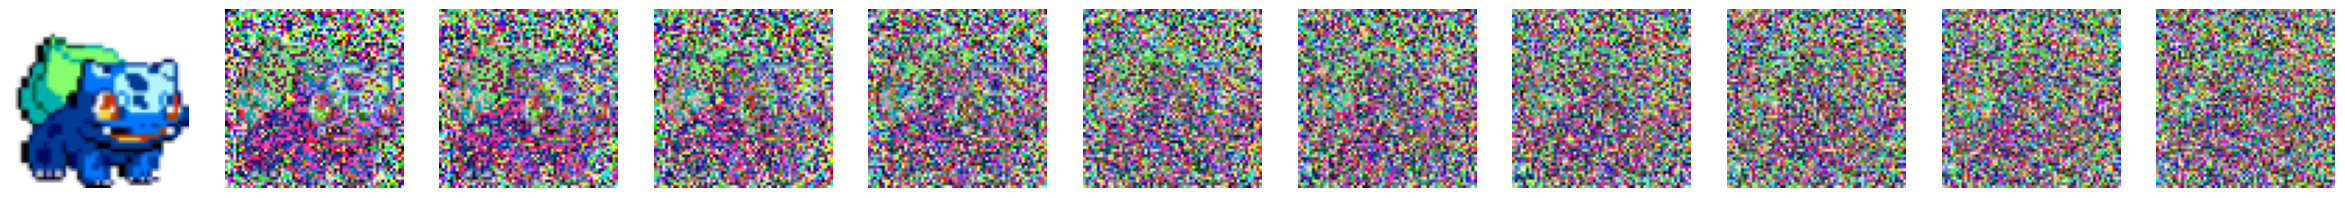

In [19]:
o, _ = dataset[0]
o = o.unsqueeze(0).to(device)
fig, axs = plt.subplots(1, 11, figsize=(30, 3))
axs[0].imshow(to_pil_image(o[0]))
axs[0].axis('off')
for i in range(10):
    o, _ = diffusion_model.apply_noise(o, 10)
    im = to_pil_image(o[0])
    axs[i + 1].imshow(im)
    axs[i + 1].axis('off')
plt.show()

In [20]:
epoch_per_pbar = 25

for ep in range(max_training_epochs):
    model.train()
    total_loss = 0
    with tqdm(total=epoch_per_pbar, desc=f'Epoch {ep * epoch_per_pbar + 1}-{(ep + 1) * epoch_per_pbar}/{max_training_epochs}', unit=f'epoch', position=0, leave=True) as pbar:
        for pbar_epoch in range(epoch_per_pbar):
            for b, (img, _) in enumerate(dataloader):
                img = img.to(device)
                t = random.randint(1, 150)
                img, noises = diffusion_model.apply_noise(img, t)
                optimizer.zero_grad()
                e_pred = model(img, t)
                loss = criterion(e_pred, noises[t - 1])
                total_loss += loss.item()
                loss.backward()
                optimizer.step()
            pbar.set_postfix(loss=total_loss / ((pbar_epoch + 1) * len(dataloader)))
            pbar.update(1)

Epoch 1-25/500:   8%|████▏                                                | 2/25 [00:16<03:12,  8.38s/epoch, loss=1.06]


KeyboardInterrupt: 

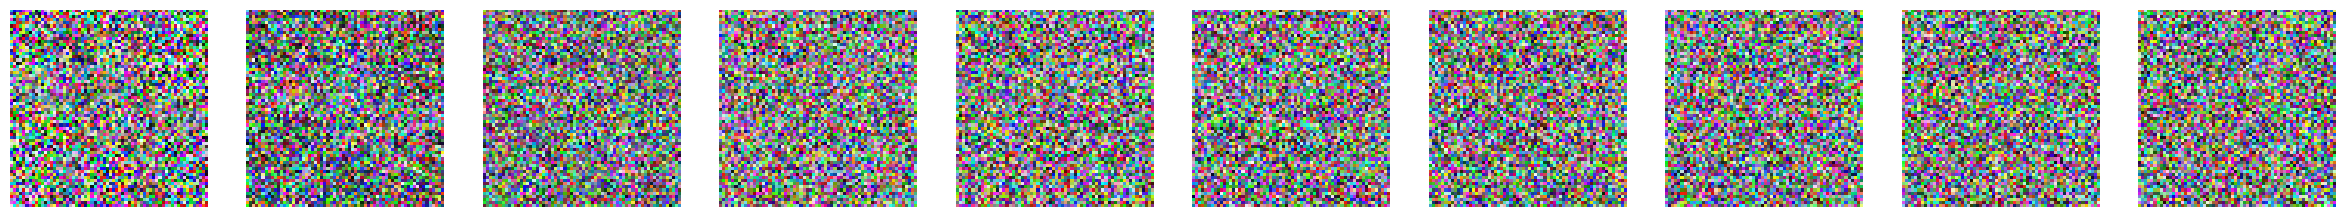

In [21]:
diffusion_model.eval()
sample = dataset[5][0].unsqueeze(0).to(device)
with torch.no_grad():
    sample, _ = diffusion_model.apply_noise(sample, 20)
inference_steps = 450
log_step = 45

fig, axs = plt.subplots(1, int(inference_steps / log_step), figsize=(30, 3))
axs[0].imshow(to_pil_image(sample[0]))
axs[0].axis('off')

model.eval()
with torch.no_grad():
    for i in range(inference_steps - 1):
        sample = diffusion_model.denoise(sample, inference_steps - i, 0)
        if (i + 1) % log_step == 0:
            axs[int((i + 1) / log_step)].imshow(to_pil_image(sample[0]))
            axs[int((i + 1) / log_step)].axis('off')

In [22]:
checkpoint = {
    'diffusion_model': diffusion_model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
torch.save(checkpoint, checkpoint_path)

In [ ]:
max_training_epochs = 5
batch_size = 8
lr = 1e-4

noise_schedule = LinearNoiseSchedule()
model = UNet().to(device)
diffusion_model = DiffusionModel(model, noise_schedule).to(device)
criterion = nn.CrossEntropyLoss()

checkpoint = torch.load(checkpoint_path, weights_only=False)
diffusion_model.load_state_dict(checkpoint['diffusion_model'])
optimizer.load_state_dict(checkpoint['optimizer'])

inference_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [ ]:
diffusion_model.eval()
sample = dataset[5][0].unsqueeze(0).to(device)
with torch.no_grad():
    sample, _ = diffusion_model.apply_noise(sample, 20)
inference_steps = 450
log_step = 45

fig, axs = plt.subplots(1, int(inference_steps / log_step), figsize=(30, 3))
axs[0].imshow(to_pil_image(sample[0]))
axs[0].axis('off')

model.eval()
with torch.no_grad():
    for i in range(inference_steps - 1):
        sample = diffusion_model.denoise(sample, inference_steps - i, 0)
        if (i + 1) % log_step == 0:
            axs[int((i + 1) / log_step)].imshow(to_pil_image(sample[0]))
            axs[int((i + 1) / log_step)].axis('off')